In [2]:
from pymongo import MongoClient
from sshtunnel import SSHTunnelForwarder
import pprint
from bson.objectid import ObjectId
import pyperclip as clip
import json
import tensorflow as tf
import pandas as pd
import numpy as np
# from datasu import auc
# import pixiedust
# clip.copy(json.dumps(m1['msg']))

### funcs

In [3]:
def df_crossjoin(df1, df2, **kwargs):
    df1['_tmpkey'] = 1
    df2['_tmpkey'] = 1

    res = pd.merge(df1, df2, on='_tmpkey', **kwargs).drop('_tmpkey', axis=1)
    res.index = pd.MultiIndex.from_product((df1.index, df2.index))

    df1.drop('_tmpkey', axis=1, inplace=True)
    df2.drop('_tmpkey', axis=1, inplace=True)

    return res

In [4]:
def get_fields_for_vector(msg):
    f = {}
    f['text'] = msg['text']
    f['positive_aspects'] = 'zzz'#msg['positive_aspects']
    return list(f.items())

In [5]:
def sim_exact_cross(embs1, embs2):
    input1 = tf.placeholder(tf.float64, shape=(None))
    input2 = tf.placeholder(tf.float64, shape=(None))

    norm1 = tf.nn.l2_normalize(input1, axis=1)
    norm2 = tf.nn.l2_normalize(input2, axis=1)
    cosine_similarities = tf.tensordot(norm1, norm2, axes=((1),(1)))
#     cosine_similarities = tf.reduce_sum(vectorsdot, axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    angular_dist = 1.0 - tf.acos(clip_cosine_similarities)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
  
        norm1, norm2, angdist, cossim = session.run([norm1, norm2, angular_dist, cosine_similarities], 
                                         feed_dict={ input1: embs1,
                                                     input2: embs2 })
          
    return angdist, cossim

In [6]:
import seaborn as sns
def plot_similarity(labels, corr): 
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=90)
    g.set_title("Semantic Textual Similarity")

In [47]:
def plot_precision_recall_curve(y_test, y_score):
    from sklearn.metrics import precision_recall_curve,average_precision_score
    import matplotlib.pyplot as plt
    from sklearn.utils.fixes import signature
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [48]:
def plot_auc_curve(y_score, y_true):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_score, y_true)

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### load data

In [9]:
MONGO_HOST = "ec2-52-23-187-115.compute-1.amazonaws.com"
MONGO_DB = "marketpulzz"
server = SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username='ubuntu',
    ssh_pkey="/Users/sasha/.ssh/mmuze.pem",
#     ssh_private_key_password="secret",
    remote_bind_address=('127.0.0.1', 27017)
)

server.start()
client = MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port
db = client[MONGO_DB]

In [10]:
# messages = list(db.genie_conversation_messages.find({"_id": ObjectId("5bf55aa4fad96c1988000002")}))

In [11]:
def get_message_for_master_tag(mt):   
    mess = db.genie_conversation_messages.find_one({"_id": mt['conversation_message_id']})
    fields = get_fields_for_vector(mess['msg'])    
    intent = mt['intents'][0]['name']
    row = {**{'intent':intent}, **dict(fields)}        
    return row
    

master_tags_cursor = db.genie_master_tags.find({"intents.0":{'$exists':True}})
data = list(map(get_message_for_master_tag, master_tags_cursor))

In [12]:
data[0]

{'intent': 'order_information',
 'text': 'can you please tell me the status of my package',
 'positive_aspects': 'zzz'}

In [32]:
df_data_all = pd.DataFrame(data)[0:2]
df_data_all[0:1]['intent'] = 'order'
df_data_all[0:1]['text'] = 'order'
df_data_all[1:]['intent'] = 'pants'
df_data_all[1:]['text'] = 'pants'

In [33]:
df_data_all.shape

(2, 3)

In [34]:
#calc intent pro
df_data_all['intent_prob'] = df_data_all.groupby(['intent']).transform('count')['text']/df_data_all.shape[0]
print(df_data_all['text'].map(len).max())
df_data_all.head()


5


,intent,positive_aspects,text,intent_prob
0,order,zzz,order,0.5
1,pants,zzz,pants,0.5


### encode data

In [26]:
#bert-serving-start -model_dir /Users/sasha/dev/mmuze/_models/BERT/uncased_L-24_H-1024_A-16/ -num_worker=1 -max_batch_size 1000 -max_seq_len 200 -pooling_strategy REDUCE_MEAN -pooling_layer -1 -2 
_models_path = '/Users/sasha/dev/mmuze/_models/BERT'
BERT_BASE_DIR=f'{_models_path}/uncased_L-24_H-1024_A-16/'

In [27]:
from bert_serving.client import BertClient
bc = BertClient()

In [37]:
text_emb_bert = bc.encode(list(df_data_all['text'].values))
df_data_all['text_emb_bert'] = list(text_emb_bert)

In [66]:
df_data_all.head()

,intent,positive_aspects,text,intent_prob,text_emb_bert
0,order,zzz,order,0.5,"[-0.30305955, -0.10030366, 0.1835521, 0.165482..."
1,pants,zzz,pants,0.5,"[-0.42753434, -0.09709713, 0.14850323, 0.40615..."


### evaluation

In [30]:
N = 30
df_query = df_data_all.sample(n=N, weights='intent_prob',random_state=108)
df_query
df_data = df_data_all.drop(df_query.index)
f"total: {len(df_data_all)} => query:{len(df_query)} + data:{len(df_data)}"

'total: 2 => query:2 + data:0'

In [67]:
df_eval = df_crossjoin(df_data_all[['text','text_emb_bert', 'intent']], df_data_all, suffixes=('_q', ''))
df_eval.head()

text_q                                    text_emb_bert_q intent_q intent  \
0 0  order  [-0.30305955, -0.10030366, 0.1835521, 0.165482...    order  order   
  1  order  [-0.30305955, -0.10030366, 0.1835521, 0.165482...    order  pants   
1 0  pants  [-0.42753434, -0.09709713, 0.14850323, 0.40615...    pants  order   
  1  pants  [-0.42753434, -0.09709713, 0.14850323, 0.40615...    pants  pants   

    positive_aspects   text  intent_prob  \
0 0              zzz  order          0.5   
  1              zzz  pants          0.5   
1 0              zzz  order          0.5   
  1              zzz  pants          0.5   

                                         text_emb_bert  
0 0  [-0.30305955, -0.10030366, 0.1835521, 0.165482...  
  1  [-0.42753434, -0.09709713, 0.14850323, 0.40615...  
1 0  [-0.30305955, -0.10030366, 0.1835521, 0.165482...  
  1  [-0.42753434, -0.09709713, 0.14850323, 0.40615...

In [64]:
df_eval

text_q                                    text_emb_bert_q intent_q intent  \
0 0  order  [-0.30305955, -0.10030366, 0.1835521, 0.165482...    order  order   
  1  order  [-0.30305955, -0.10030366, 0.1835521, 0.165482...    order  pants   
1 0  pants  [-0.42753434, -0.09709713, 0.14850323, 0.40615...    pants  order   

    positive_aspects   text  intent_prob  \
0 0              zzz  order          0.5   
  1              zzz  pants          0.5   
1 0              zzz  order          0.5   

                                         text_emb_bert  angdist_bert  \
0 0  [-0.30305955, -0.10030366, 0.1835521, 0.165482...      1.000000   
  1  [-0.42753434, -0.09709713, 0.14850323, 0.40615...      0.492261   
1 0  [-0.30305955, -0.10030366, 0.1835521, 0.165482...      0.492261   

     cossim_bert  
0 0     1.000000  
  1     0.873846  
1 0     0.873846

In [68]:
angdist, cossim = sim_exact_cross(np.stack(df_eval['text_emb_bert_q'].values), np.stack(df_eval['text_emb_bert'].values))
df_eval['angdist_bert'] = angdist.diagonal()
df_eval['cossim_bert'] = cossim.diagonal()
# df_eval_by_angdist = df_eval.sort_values(by=['angdist_bert'], ascending=False)
df_eval.head()

text_q                                    text_emb_bert_q intent_q intent  \
0 0  order  [-0.30305955, -0.10030366, 0.1835521, 0.165482...    order  order   
  1  order  [-0.30305955, -0.10030366, 0.1835521, 0.165482...    order  pants   
1 0  pants  [-0.42753434, -0.09709713, 0.14850323, 0.40615...    pants  order   
  1  pants  [-0.42753434, -0.09709713, 0.14850323, 0.40615...    pants  pants   

    positive_aspects   text  intent_prob  \
0 0              zzz  order          0.5   
  1              zzz  pants          0.5   
1 0              zzz  order          0.5   
  1              zzz  pants          0.5   

                                         text_emb_bert  angdist_bert  \
0 0  [-0.30305955, -0.10030366, 0.1835521, 0.165482...      1.000000   
  1  [-0.42753434, -0.09709713, 0.14850323, 0.40615...      0.492261   
1 0  [-0.30305955, -0.10030366, 0.1835521, 0.165482...      0.492261   
  1  [-0.42753434, -0.09709713, 0.14850323, 0.40615...      1.000000   

     cossim_bert  
0 0     1.000000  
  1     0.873846  
1 0     0.873846  
  1     1.000000

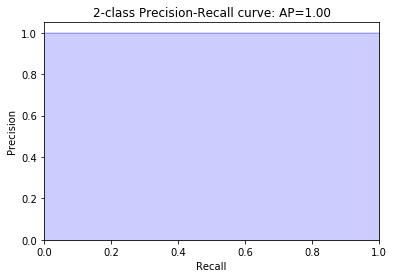

In [70]:
y_test = (df_eval['intent_q'] == df_eval['intent']).values
y_score = df_eval['angdist_bert'].values

plot_precision_recall_curve(y_test, y_score)

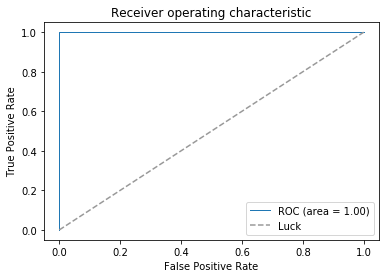

2018-12-31 18:41:58,102| ERROR   | Could not establish connection from ('127.0.0.1', 54390) to remote side of the tunnel
2018-12-31 18:42:09,244| ERROR   | Could not establish connection from ('127.0.0.1', 54390) to remote side of the tunnel
2018-12-31 19:35:49,167| ERROR   | Socket exception: Operation timed out (60)
2018-12-31 19:35:51,036| ERROR   | Could not establish connection from ('127.0.0.1', 54390) to remote side of the tunnel
2018-12-31 20:17:09,587| ERROR   | Could not establish connection from ('127.0.0.1', 54390) to remote side of the tunnel
2018-12-31 20:28:19,640| ERROR   | Could not establish connection from ('127.0.0.1', 54390) to remote side of the tunnel
2018-12-31 20:28:29,769| ERROR   | Could not establish connection from ('127.0.0.1', 54390) to remote side of the tunnel
2018-12-31 20:28:39,861| ERROR   | Could not establish connection from ('127.0.0.1', 54390) to remote side of the tunnel
2018-12-31 20:28:49,952| ERROR   | Could not establish connection from ('12

In [71]:
plot_auc_curve(y_test, y_score)

In [ ]:
m1 = messages[0]
get_fields_for_vector(m1['msg'])

In [ ]:
server.stop()

In [ ]:
messages = ["jeans", "denim", "pants", "trousers",
            "package", "parcel", 
            "hot", "cold", 
            "I do not like you", "I love you",
            "The package didn't arrived, what happens with it", "I havn't received my order yet", "My tracking number doesn't work. Can you help?"]

In [ ]:
embs = bc.encode(messages)

In [ ]:
embs.shape

In [ ]:
sim_e_c, cosine_similarities_ec = sim_exact_cross(embs[0:2],embs[1:3])
plot_similarity(messages, sim_e_c)

In [ ]:
sim_e_c